<a href="https://colab.research.google.com/github/santiagorg2401/pytorch_course_exercises/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [43]:
# Check for GPU
!nvidia-smi

Fri Jul 26 14:38:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [44]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.1+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Training for longer
2. Add more layers
3. Transfer learning

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [10]:
# 1. Get data
import os
import zipfile
import requests
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  pass
else:
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

os.remove(data_path / "pizza_steak_sushi.zip")

In [12]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [14]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

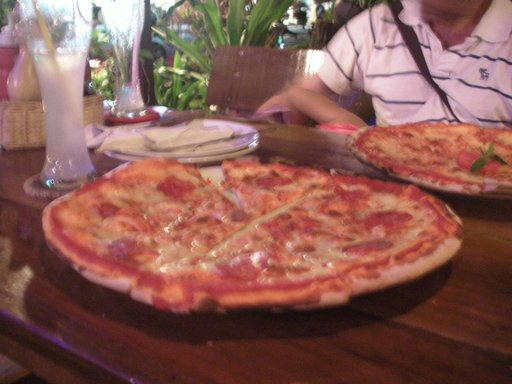

In [22]:
# Visualize an image
from PIL import Image
img_path_list = list(image_path.glob("*/*/*.jpg"))
img = Image.open(img_path_list[0])
img

(-0.5, 511.5, 383.5, -0.5)

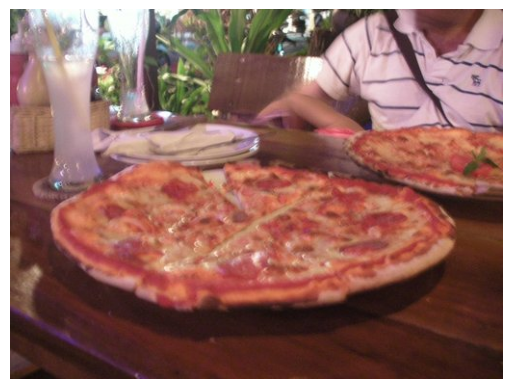

In [23]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img = np.array(img)
plt.imshow(img)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [26]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [29]:
# Write transform for turning images into tensors
IMG_SIZE = (128, 128)
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

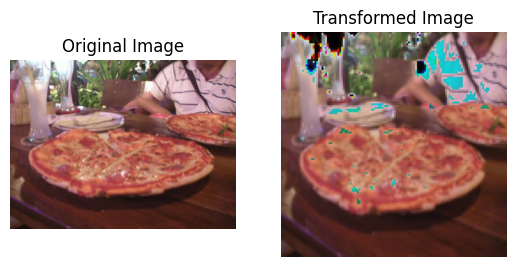

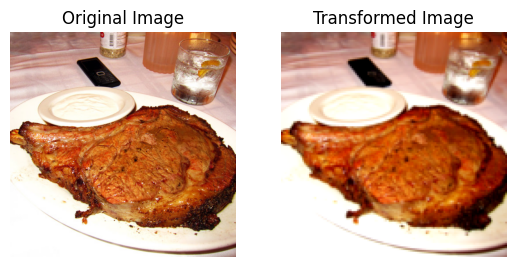

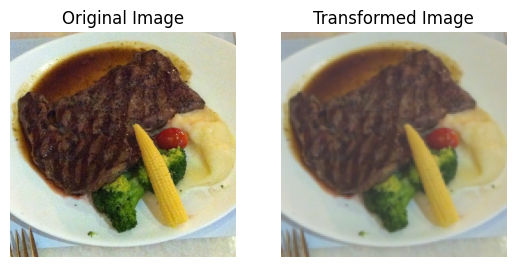

In [32]:
# Write a function to plot transformed images
import random
def plot_transformed_imgs(transform,
                          img_paths,
                          n=3):
  # Load Images
  rand_img_paths = random.sample(img_paths, k=n)
  for img_path in rand_img_paths:
    with Image.open(img_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title("Original Image")
      ax[0].axis(False)

      trans_img = transform(f).permute(1, 2, 0)
      ax[1].imshow(trans_img)
      ax[1].set_title("Transformed Image")
      ax[1].axis(False)
plot_transformed_imgs(train_transform, img_path_list)

### Load image data using `ImageFolder`

In [33]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

In [34]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [35]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [37]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data, BATCH_SIZE, True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, BATCH_SIZE, False,
                             num_workers=NUM_WORKERS)

In [41]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [74]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, 3),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*29*29, output_shape)
    )
  def forward(self, x):
    return self.classifier(
        self.conv_block_2(
            self.conv_block_1(x)
        )
    )
model_0 = TinyVGG(3, 10, len(class_names)).to(device)

## 4. Create training and testing functions for `model_0`.

In [77]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


In [81]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss

      # Calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)


    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /=  len(dataloader)

  return test_loss, test_acc

In [85]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss.to("cpu").detach().numpy())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.to("cpu").detach().numpy())
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [83]:
def plot_loss_curves(results):
  epochs = range(len(results["train_loss"]))
  # Loss
  plt.figure(figsize=(15,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results["train_loss"], label="Train")
  plt.plot(epochs, results["test_loss"], label="Test")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results["train_acc"], label="Train")
  plt.plot(epochs, results["test_acc"], label="Test")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0093 | train_acc: 0.5195 | test_loss: 1.0741 | test_acc: 0.3513
Epoch: 2 | train_loss: 1.0179 | train_acc: 0.5469 | test_loss: 1.1391 | test_acc: 0.3523
Epoch: 3 | train_loss: 0.9469 | train_acc: 0.4961 | test_loss: 1.0824 | test_acc: 0.3930
Epoch: 4 | train_loss: 0.9700 | train_acc: 0.5547 | test_loss: 1.1193 | test_acc: 0.3220
Epoch: 5 | train_loss: 0.8746 | train_acc: 0.5898 | test_loss: 1.1251 | test_acc: 0.3636


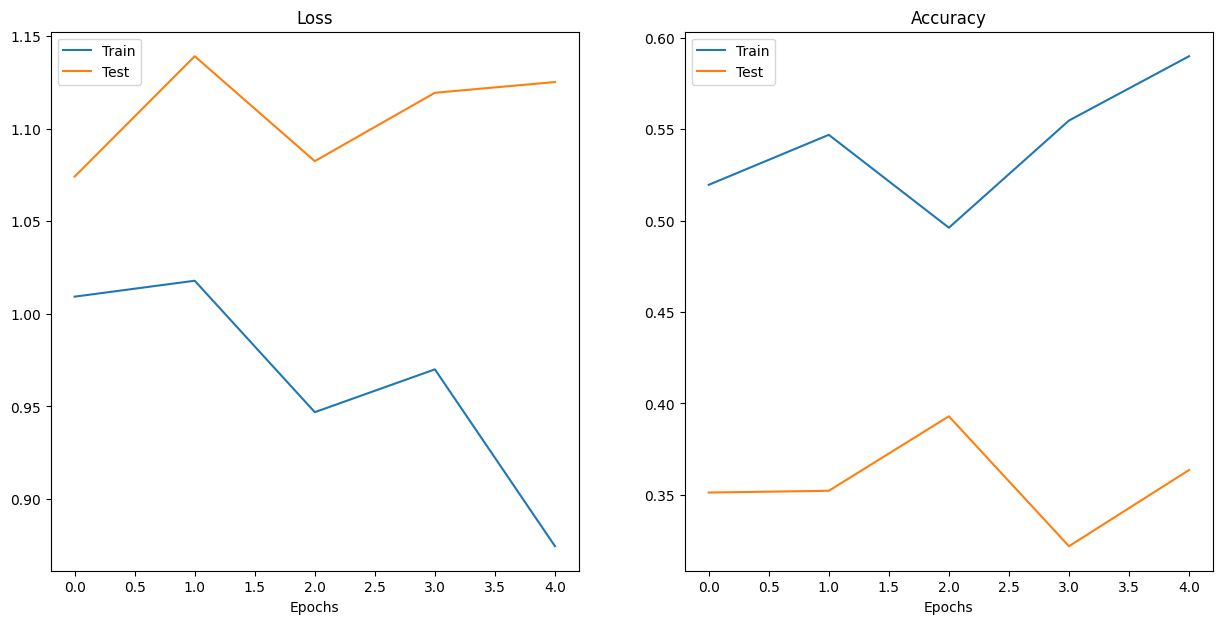

In [86]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
model_0_results = train(model_0, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 5)
plot_loss_curves(model_0_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9220 | train_acc: 0.5469 | test_loss: 1.0534 | test_acc: 0.3826
Epoch: 2 | train_loss: 0.9930 | train_acc: 0.4609 | test_loss: 1.0945 | test_acc: 0.4034
Epoch: 3 | train_loss: 0.8822 | train_acc: 0.5703 | test_loss: 1.0532 | test_acc: 0.3930
Epoch: 4 | train_loss: 0.8742 | train_acc: 0.5781 | test_loss: 1.1357 | test_acc: 0.3731
Epoch: 5 | train_loss: 0.8143 | train_acc: 0.5938 | test_loss: 1.0742 | test_acc: 0.4138
Epoch: 6 | train_loss: 0.9935 | train_acc: 0.4531 | test_loss: 1.0249 | test_acc: 0.4545
Epoch: 7 | train_loss: 0.9450 | train_acc: 0.5586 | test_loss: 1.1549 | test_acc: 0.3636
Epoch: 8 | train_loss: 0.9712 | train_acc: 0.4297 | test_loss: 1.1664 | test_acc: 0.4347
Epoch: 9 | train_loss: 0.9564 | train_acc: 0.4766 | test_loss: 1.0365 | test_acc: 0.4347
Epoch: 10 | train_loss: 0.9546 | train_acc: 0.4531 | test_loss: 0.9697 | test_acc: 0.5540
Epoch: 11 | train_loss: 0.9408 | train_acc: 0.5742 | test_loss: 1.0185 | test_acc: 0.4650
Epoch: 12 | train_l

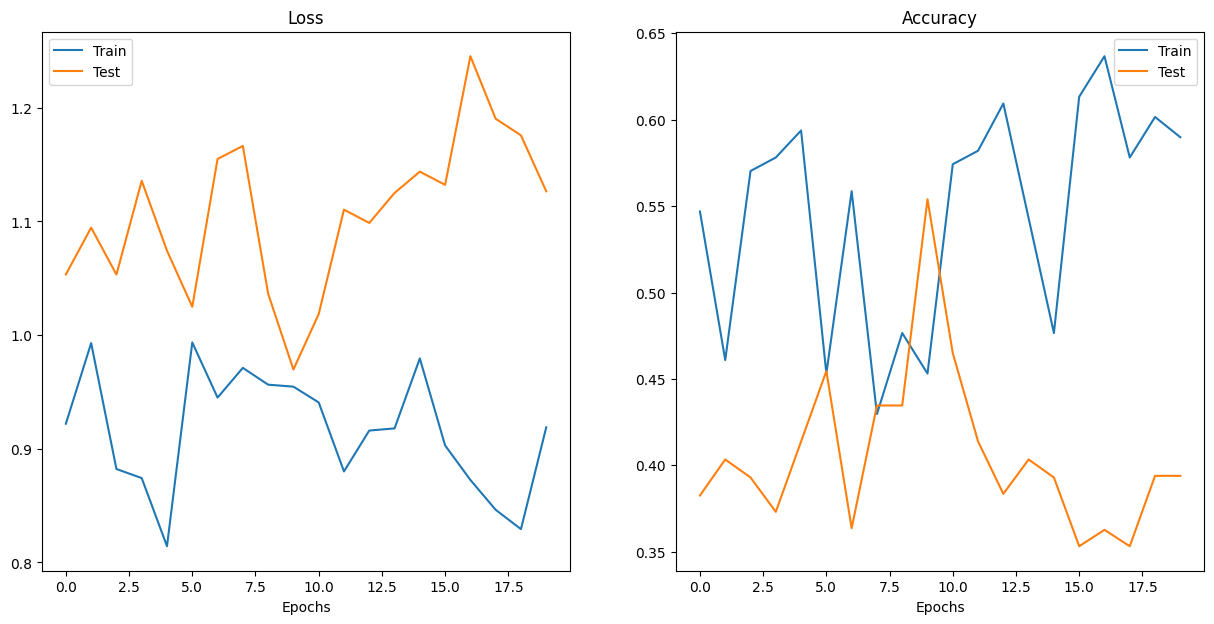

In [88]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
model_0_results = train(model_0, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 20)
plot_loss_curves(model_0_results)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8160 | train_acc: 0.5898 | test_loss: 1.1566 | test_acc: 0.3125
Epoch: 2 | train_loss: 0.8596 | train_acc: 0.6289 | test_loss: 1.2007 | test_acc: 0.4441
Epoch: 3 | train_loss: 0.8090 | train_acc: 0.6406 | test_loss: 1.0296 | test_acc: 0.4555
Epoch: 4 | train_loss: 0.7645 | train_acc: 0.6484 | test_loss: 1.2219 | test_acc: 0.4034
Epoch: 5 | train_loss: 0.7451 | train_acc: 0.6680 | test_loss: 1.0931 | test_acc: 0.4242
Epoch: 6 | train_loss: 0.8952 | train_acc: 0.5117 | test_loss: 1.0191 | test_acc: 0.4754
Epoch: 7 | train_loss: 0.8597 | train_acc: 0.6211 | test_loss: 1.1915 | test_acc: 0.4356
Epoch: 8 | train_loss: 0.8188 | train_acc: 0.6406 | test_loss: 1.1411 | test_acc: 0.4441
Epoch: 9 | train_loss: 0.7993 | train_acc: 0.7031 | test_loss: 1.0041 | test_acc: 0.5066
Epoch: 10 | train_loss: 0.8603 | train_acc: 0.6133 | test_loss: 0.9780 | test_acc: 0.4858
Epoch: 11 | train_loss: 0.7905 | train_acc: 0.6523 | test_loss: 1.2372 | test_acc: 0.3939
Epoch: 12 | train_l

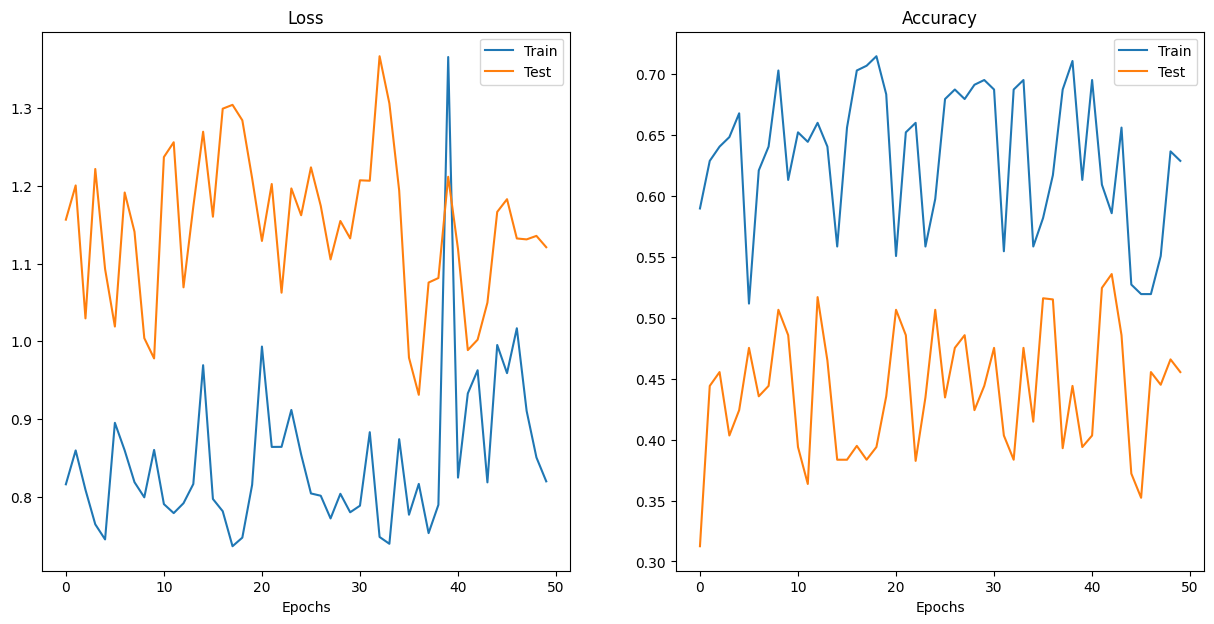

In [89]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
model_0_results = train(model_0, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 50)
plot_loss_curves(model_0_results)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1032 | train_acc: 0.4062 | test_loss: 1.0947 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0871 | train_acc: 0.4297 | test_loss: 1.1222 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0595 | train_acc: 0.4258 | test_loss: 1.1361 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0744 | train_acc: 0.4648 | test_loss: 1.0751 | test_acc: 0.3627
Epoch: 5 | train_loss: 1.0495 | train_acc: 0.3906 | test_loss: 1.0442 | test_acc: 0.4044
Epoch: 6 | train_loss: 1.0858 | train_acc: 0.4609 | test_loss: 1.0567 | test_acc: 0.3627
Epoch: 7 | train_loss: 1.0141 | train_acc: 0.5117 | test_loss: 0.9422 | test_acc: 0.5833
Epoch: 8 | train_loss: 1.0104 | train_acc: 0.4023 | test_loss: 0.9762 | test_acc: 0.5833
Epoch: 9 | train_loss: 0.9959 | train_acc: 0.5352 | test_loss: 1.0417 | test_acc: 0.3125
Epoch: 10 | train_loss: 0.9708 | train_acc: 0.4414 | test_loss: 1.0140 | test_acc: 0.3419
Epoch: 11 | train_loss: 0.8727 | train_acc: 0.6055 | test_loss: 0.9236 | test_acc: 0.4924
Epoch: 12 | train_l

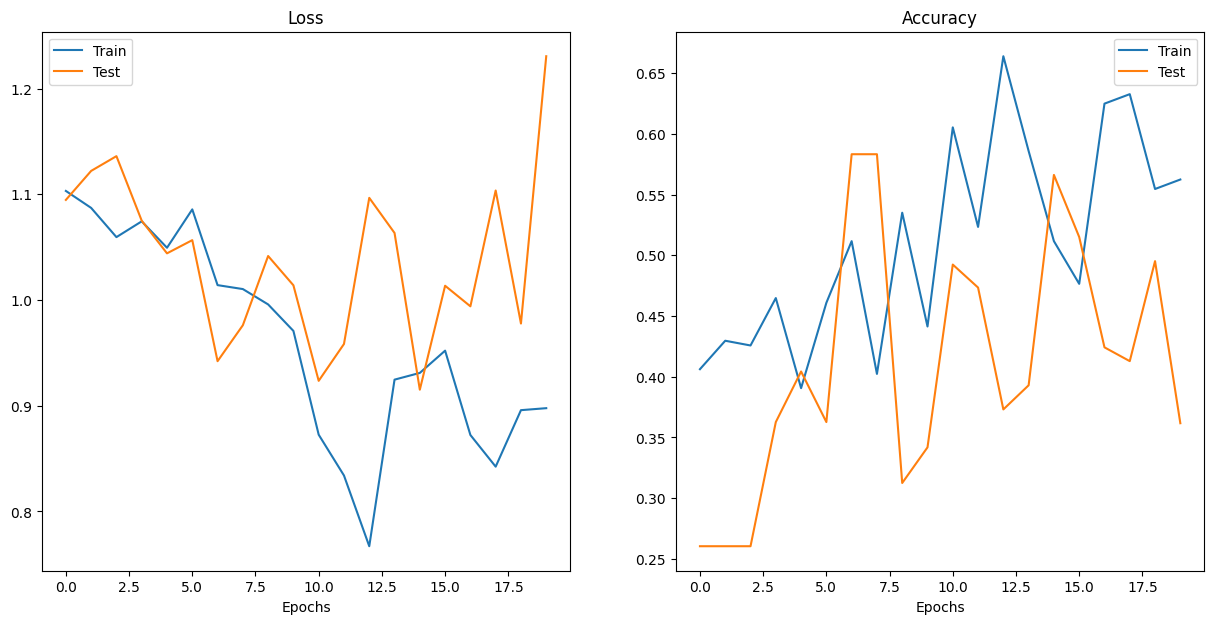

In [91]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(3, 20, len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
model_1_results = train(model_1, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 20)
plot_loss_curves(model_1_results)

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [92]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [93]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Excellent, we now have double the training and testing images...

In [94]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [98]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize(IMG_SIZE),
  transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(train_data_20_percent_path,
                                  simple_transform)
test_data = datasets.ImageFolder(test_data_20_percent_path,
                                 simple_transform)

# Create dataloaders
train_dataloader = DataLoader(train_data, BATCH_SIZE, True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, BATCH_SIZE, False,
                             num_workers=NUM_WORKERS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1647 | train_acc: 0.9542 | test_loss: 1.6281 | test_acc: 0.5506
Epoch: 2 | train_loss: 0.0463 | train_acc: 0.9938 | test_loss: 2.1455 | test_acc: 0.5659
Epoch: 3 | train_loss: 0.0167 | train_acc: 0.9958 | test_loss: 2.2690 | test_acc: 0.5761
Epoch: 4 | train_loss: 0.0182 | train_acc: 0.9979 | test_loss: 2.7058 | test_acc: 0.5665
Epoch: 5 | train_loss: 0.0062 | train_acc: 1.0000 | test_loss: 2.5564 | test_acc: 0.5653
Epoch: 6 | train_loss: 0.0025 | train_acc: 1.0000 | test_loss: 2.7583 | test_acc: 0.5750
Epoch: 7 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 2.8319 | test_acc: 0.5750
Epoch: 8 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 2.9097 | test_acc: 0.5687
Epoch: 9 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 2.9895 | test_acc: 0.5687
Epoch: 10 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 3.0537 | test_acc: 0.5534
Epoch: 11 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 3.1166 | test_acc: 0.5472
Epoch: 12 | train_l

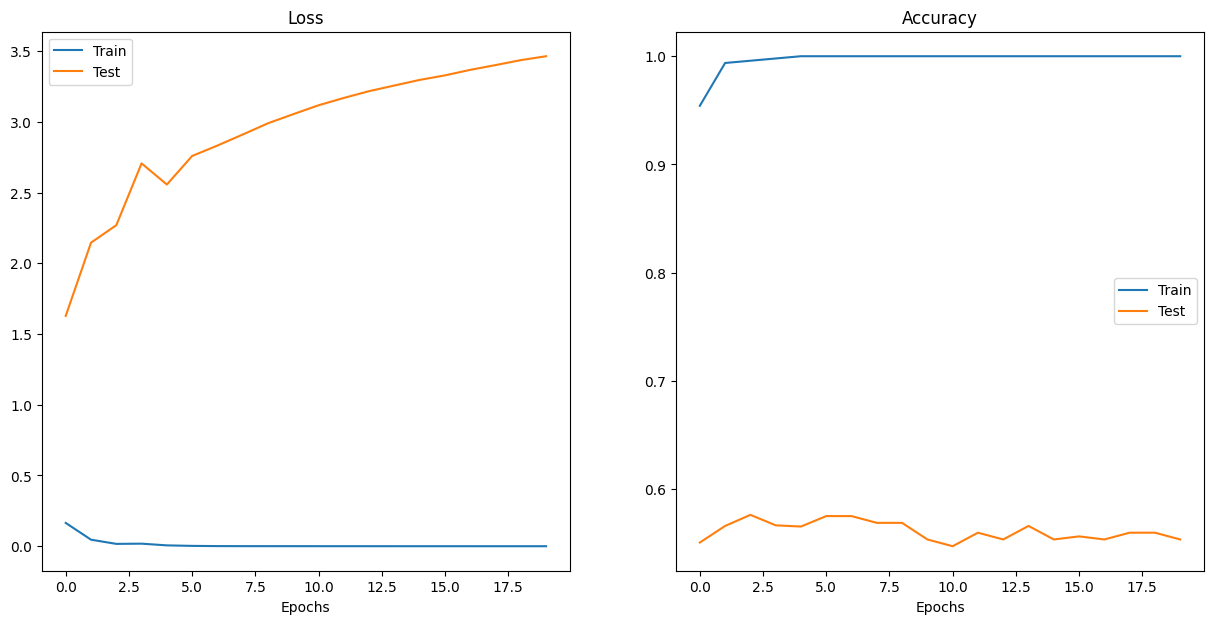

In [99]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
model_1_results = train(model_1, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 20)
plot_loss_curves(model_1_results)

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1270 | train_acc: 0.3688 | test_loss: 1.1211 | test_acc: 0.3500
Epoch: 2 | train_loss: 1.1170 | train_acc: 0.3833 | test_loss: 1.0967 | test_acc: 0.4375
Epoch: 3 | train_loss: 1.0922 | train_acc: 0.4229 | test_loss: 1.0734 | test_acc: 0.4653
Epoch: 4 | train_loss: 1.0776 | train_acc: 0.4104 | test_loss: 1.0290 | test_acc: 0.4903
Epoch: 5 | train_loss: 1.0028 | train_acc: 0.5146 | test_loss: 0.9634 | test_acc: 0.4614
Epoch: 6 | train_loss: 0.9741 | train_acc: 0.5375 | test_loss: 0.9498 | test_acc: 0.5216
Epoch: 7 | train_loss: 0.9948 | train_acc: 0.5021 | test_loss: 0.9790 | test_acc: 0.4977
Epoch: 8 | train_loss: 1.0173 | train_acc: 0.4375 | test_loss: 0.9386 | test_acc: 0.5091
Epoch: 9 | train_loss: 0.9552 | train_acc: 0.5417 | test_loss: 0.9294 | test_acc: 0.5409
Epoch: 10 | train_loss: 0.9689 | train_acc: 0.5062 | test_loss: 0.9297 | test_acc: 0.5500
Epoch: 11 | train_loss: 0.9213 | train_acc: 0.5354 | test_loss: 0.9348 | test_acc: 0.4852
Epoch: 12 | train_l

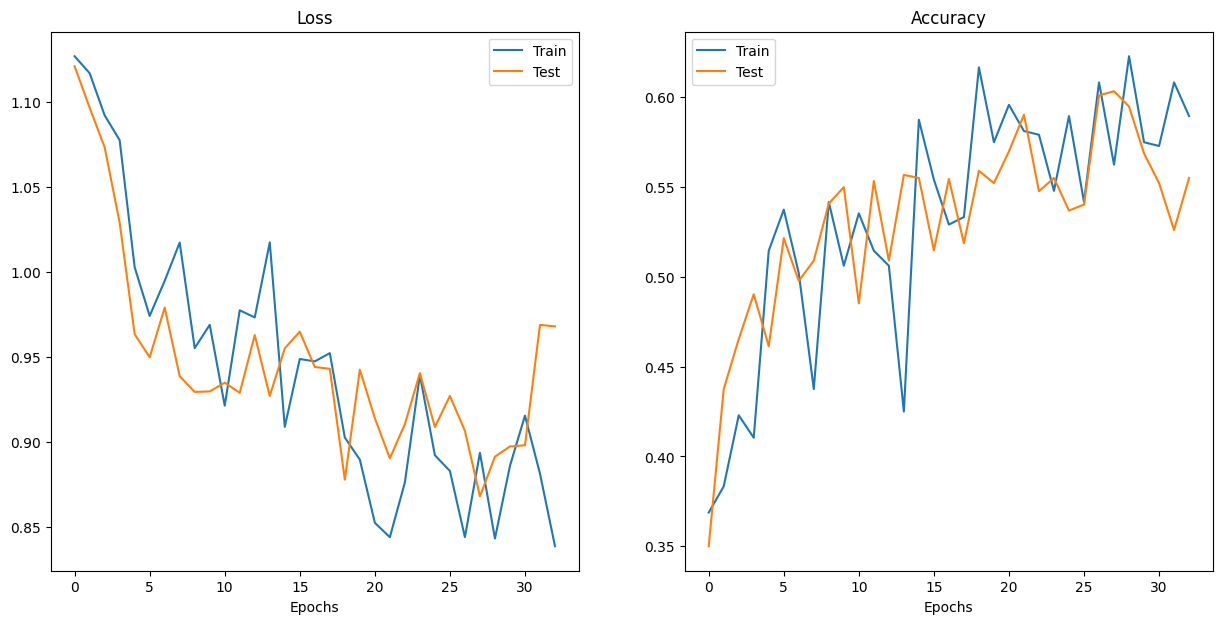

In [109]:
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(train_data_20_percent_path,
                                  train_transform)
test_data = datasets.ImageFolder(test_data_20_percent_path,
                                 test_transform)

# Create dataloaders
train_dataloader = DataLoader(train_data, BATCH_SIZE, True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, BATCH_SIZE, False,
                             num_workers=NUM_WORKERS)

# Train
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(3, 30, len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)
model_2_results = train(model_2, train_dataloader, test_dataloader,
                        optimizer, loss_fn, 33)
plot_loss_curves(model_2_results)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [105]:
custom_img_path = data_path / "custom_img.jpg"
with open(custom_img_path, "wb") as f:
  request = requests.get("https://www.justonecookbook.com/wp-content/uploads/2020/01/Sushi-Rolls-Maki-Sushi-%E2%80%93-Hosomaki-1106-II.jpg")
  f.write(request.content)

In [104]:
import torchvision
def predict(model: nn.Module,
            device,
            class_names,
            img_shape,
            img= None,
            img_path= None):

  # Load image
  if img_path:
    img = torchvision.io.read_image(str(img_path)).type(torch.float32)/255

  log = f"Loaded image shape: {img.shape}"
  plt.imshow(img.permute(1, 2, 0))
  plt.axis(False)

  # Preprocess Image
  img = transforms.Resize(img_shape)(img)
  log += f"\nPreprocesed image shape: {img.shape}"

  # Predict
  model.to(device)
  model.eval()
  with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(device))
    prob = torch.softmax(pred, dim=1)
    pred_class = class_names[torch.argmax(prob, dim=1)]

  plt.title(f"Class: {pred_class} | Prob: {prob.max():.2f}")

  # Print log
  print(log)

Loaded image shape: torch.Size([3, 1200, 800])
Preprocesed image shape: torch.Size([3, 128, 128])


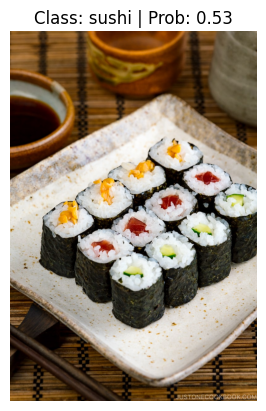

In [110]:
predict(model_2, device, class_names, IMG_SIZE, img_path=custom_img_path)